In [1]:
import pickle

import pandas as pd
import numpy as np
import pymc as pm
import arviz as az
from scipy import stats

import matplotlib.pyplot as plt
from plotnine import *
from statstools.patchwork import PGrid
theme_set(theme_bw())

/home/rileyw/miniforge3/envs/pymc_env/lib/python3.13/site-packages/statstools/patchwork.py:6: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.


In [3]:
mask = pd.read_csv("masking_tape.csv")

# Exploratory Data Analysis

## Number of Seeps

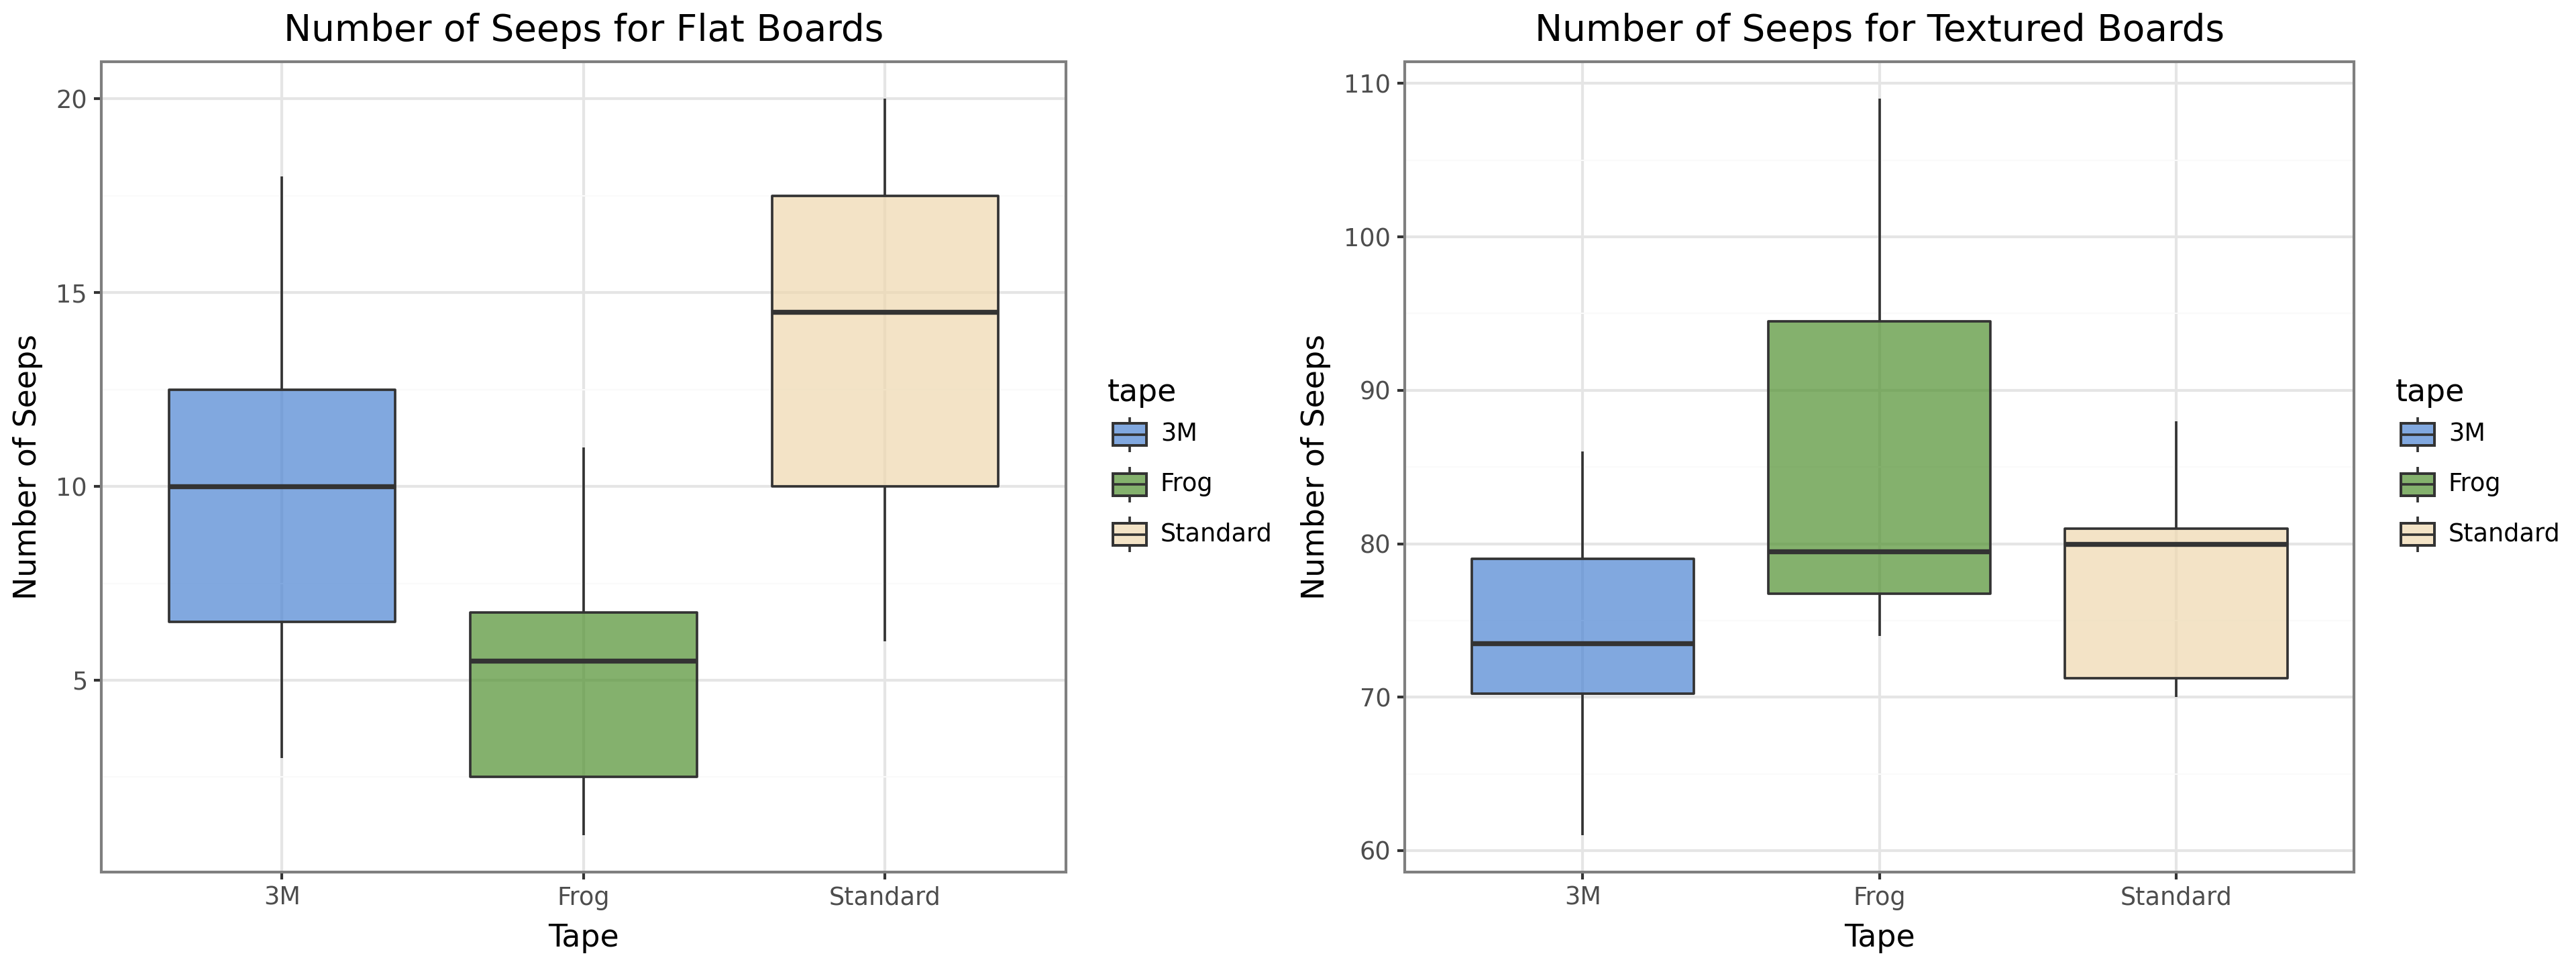

In [6]:
Flat = ggplot(mask[mask["texture"] == "Flat"]) \
+ geom_boxplot(aes(y = 'num_seeps',x = 'tape',fill = 'tape'), alpha = 0.7) \
+ scale_fill_manual(values = ['#4b83d2','#4f8f2e',  '#EED8AE']) \
+ labs(
    title = "Number of Seeps for Flat Boards",
    x = "Tape",
    y = "Number of Seeps"
)
Textured = ggplot(mask[mask["texture"] == "Textured"]) \
+ geom_boxplot(aes(y = 'num_seeps',x = 'tape',fill = 'tape'), alpha = 0.7) \
+ scale_fill_manual(values = ['#4b83d2','#4f8f2e',  '#EED8AE']) \
+ labs(
    title = "Number of Seeps for Textured Boards",
    x = "Tape",
    y = "Number of Seeps"
)

grid = PGrid({"Flat" : Flat,
              "Textured" : Textured})
grid.quilt("Flat + Textured")

Right off of the bat, it does look like there is a clear difference among the tapes for the flat boards and it looks like the textured boards don't have much of a difference it terms of seepage.

Additionally, it looks like the poisson distribution might be a resonable model for the data, as it seems as though the variance increases as the mean increases

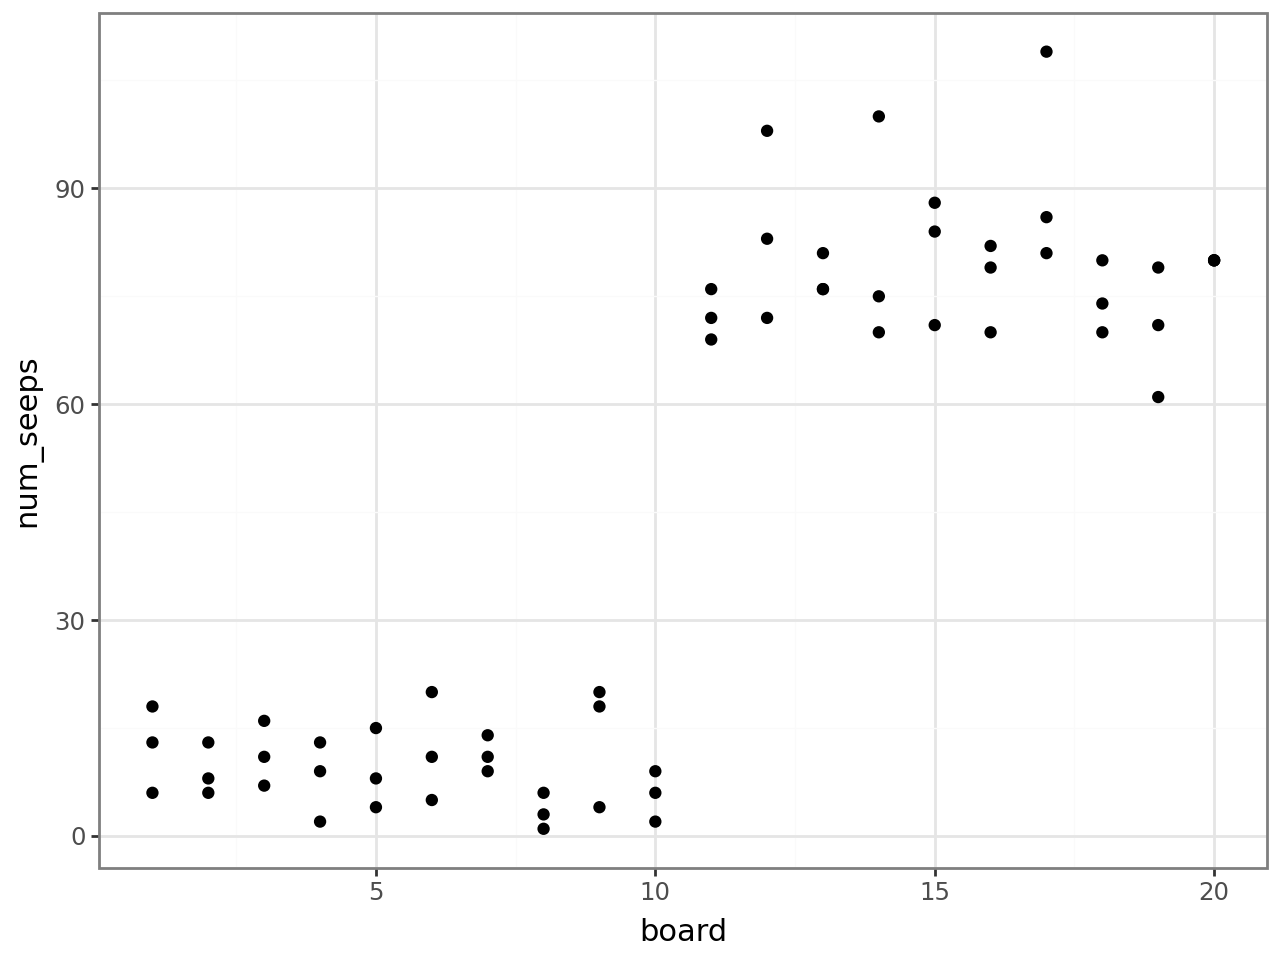

In [7]:
ggplot(mask) \
+ geom_point(aes(x = "board", y = "num_seeps"))

Luckily it doesn't look as though tehre is any sort of linear patter over time as we were counting the number of seeps

# Analysis

In [7]:
# Bookkeeping
mask['board_idx'] = mask['board'].factorize()[0]
mask['texture_idx'] = mask['texture'].factorize()[0]
mask['tape_idx'] = mask['tape'].factorize()[0]

# Create Cell 
mask['cell'] = mask['texture'] \
    .str \
    .cat(mask['tape'], sep = ":")
mask['cell_idx'] = mask['cell'].factorize()[0]

In [8]:
mask \
    [['tape', 'texture', 'num_seeps']] \
    .groupby(['tape', 'texture']) \
    .mean() \
    .reset_index() \
    .assign(log_mean = lambda r: np.log(r['num_seeps']))

,tape,texture,num_seeps,log_mean
0,3M,Flat,9.6,2.261763
1,3M,Textured,74.2,4.306764
2,Frog,Flat,5.2,1.648659
3,Frog,Textured,85.5,4.448516
4,Standard,Flat,14.0,2.639057
5,Standard,Textured,77.6,4.351567


In [9]:
np.log(np.mean(mask["num_seeps"]))

np.float64(3.7921127087555884)

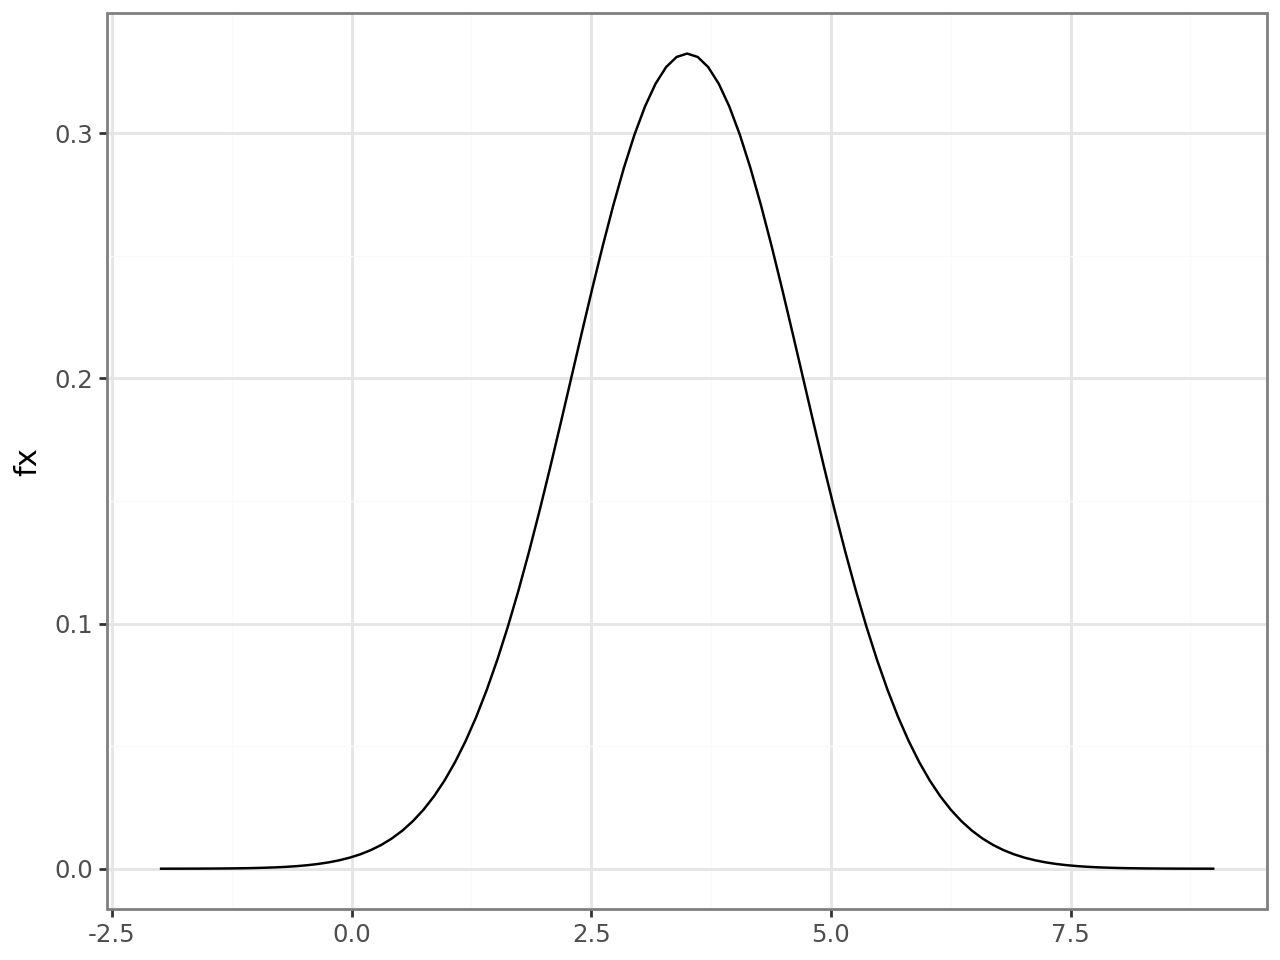

In [10]:
# Investigate different choices of priors
ggplot() \
+ stat_function(fun = stats.norm.pdf, args = {"loc" : 3.5, "scale" : 1.2}) \
+ xlim(-2, 9)

In [ ]:
coords = {
    "tape" : ["Frog", "3M", "Standard"],
    "texture" : ["Flat", "Textured"],
    "board" : np.arange(20),
    "obs_id" : np.arange(mask.shape[0])
}

with pm.Model(coords=coords) as model:
    # Data
    tape_idx = pm.Data("tape_idx", mask['tape_idx'], dims = "obs_id")
    texture_idx = pm.Data("texture_idx", mask['texture_idx'], dims = "obs_id")
    board_idx = pm.Data("board_idx", mask['board_idx'], dims = "obs_id")
    Y_data = pm.Data("Y_data", mask['num_seeps'], dims = "obs_id")
    # Variance Parameters
    sigma_b = pm.HalfCauchy("sigma_b", beta = 3)

    # Fixed Effect Priors
    means = pm.Normal("means", mu = 3.5, sigma = 1.2,dims = ("tape", "texture"))

    # Random Effect Priors
    rand_eff_offset = pm.Normal("board_eff_offset", mu = 0, sigma = 1, dims = "board")
    rand_eff = pm.Deterministic("board_eff", rand_eff_offset * sigma_b)

    # Model Formulation
    lam = pm.math.exp(means[tape_idx, texture_idx] + rand_eff[board_idx])

    y = pm.Poisson("y", mu = lam, observed = Y_data, dims = "obs_id")

In [27]:
with model:
    idata = pm.sample(
        draws=80000,
        tune = 10000,
        progressbar="split",
        target_accept = 0.99
    )

Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma_b, means, board_eff_offset]


Output()

Sampling 4 chains for 10_000 tune and 80_000 draw iterations (40_000 + 320_000 draws total) took 721 seconds.


In [ ]:
with open("results.pkl", 'wb') as file:
    pickle.dump(idata, file)

In [2]:
with open("results.pkl", "rb") as file:
    idata = pickle.load(file)

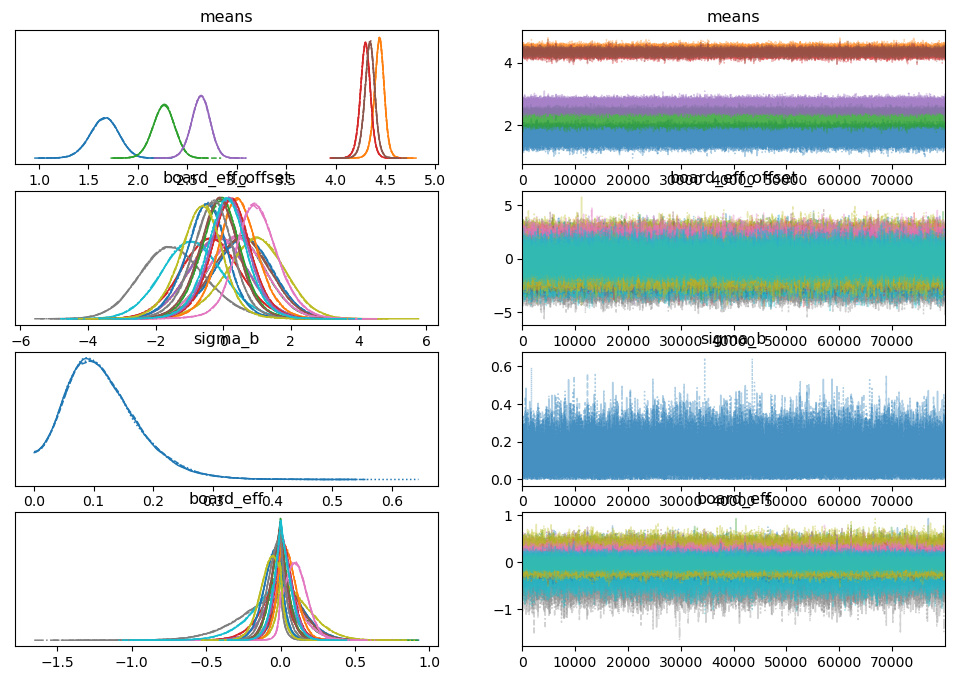

In [9]:
az.plot_trace(idata.posterior)
plt.show()

In [10]:
post_summary = az.summary(idata)

In [11]:
post_summary.reset_index()

,index,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
0,"means[Frog, Flat]",1.659,0.143,1.388,1.925,0.000,0.000,266893.0,220269.0,1.0
1,"means[Frog, Textured]",4.442,0.053,4.339,4.541,0.000,0.000,80539.0,95697.0,1.0
2,"means[3M, Flat]",2.260,0.110,2.053,2.465,0.000,0.000,234048.0,205956.0,1.0
3,"means[3M, Textured]",4.300,0.055,4.196,4.405,0.000,0.000,82527.0,97417.0,1.0
4,"means[Standard, Flat]",2.635,0.094,2.456,2.810,0.000,0.000,222880.0,207452.0,1.0
5,"means[Standard, Textured]",4.344,0.055,4.239,4.446,0.000,0.000,80020.0,95221.0,1.0
6,board_eff_offset[0],0.565,0.878,-1.095,2.218,0.002,0.002,256737.0,208520.0,1.0
7,board_eff_offset[1],-0.148,0.872,-1.789,1.508,0.002,0.002,288385.0,224886.0,1.0
8,board_eff_offset[2],0.354,0.871,-1.313,1.973,0.002,0.002,306303.0,225650.0,1.0
9,board_eff_offset[3],-0.368,0.882,-2.017,1.315,0.002,0.002,298596.0,225201.0,1.0


In [3]:
post_means = idata.posterior["means"]

In [4]:
# Flatten the means to create a matrix
flat_means = post_means \
    .stack(sample = ("chain", "draw"),
           cell = ("tape", "texture")) \
    .transpose("sample", "cell") # Ensure that the dimensions are correct

# Check the Order of the Means in the matrix
flat_means.cell.values

array([('Frog', 'Flat'), ('Frog', 'Textured'), ('3M', 'Flat'),
       ('3M', 'Textured'), ('Standard', 'Flat'), ('Standard', 'Textured')],
      dtype=object)

In [5]:
# Define Contrast Matrix
Contrasts = np.array([[-0.5, -0.5, 0.5, 0.5, 0, 0], # Overall effect of Frog Tape over 3M (frog tape has x times less seeps than 3m)
                      [0, 0, -0.5, -0.5, 0.5, 0.5], # Overall effect of 3M tape over Standard (3M has x times less seeps than Standard)
                      [-1/3, 1/3, -1/3, 1/3, -1/3, 1/3], # Overall effect of texture (flat has x times less seeps than textured)
                      [0, 0, 1, -1, -1, 1],
                      [1, -1, -1, 1, 0, 0]]) # Interaction

In [6]:
c_dist = flat_means.values @ Contrasts.T

In [7]:
print((c_dist[:,4] > 0).mean())
print((c_dist[:,3] > 0).mean())

3.125e-06
0.009503125


It appears that there is a high probability of an interaction between the variables, so we need to look at the effects individually for flat and for textured

In [8]:
flat_means.cell.values

array([('Frog', 'Flat'), ('Frog', 'Textured'), ('3M', 'Flat'),
       ('3M', 'Textured'), ('Standard', 'Flat'), ('Standard', 'Textured')],
      dtype=object)

In [9]:
del post_means

In [10]:
# 3M - Frog: Flat
c1 = [-1, 0, 1, 0, 0, 0]

# Standard - 3M: Flat
c2 = [0, 0, -1, 0, 1, 0]

# 3M - Frog: Textured
c3 = [0, -1, 0, 1, 0, 0]

# Standard - 3M: Textured
c4 = [0, 0, 0, -1, 0, 1]

Contrasts = np.array([c1,c2,c3,c4])

In [11]:
c_dist = flat_means.values @ Contrasts.T

In [12]:
to_plot = c_dist[::10, 0]

In [13]:
orig_to_plot = np.exp(to_plot)

In [14]:
hdi_log = az.hdi(c_dist[:,0])
hdi_orig = az.hdi(np.exp(c_dist[:,0]))

In [15]:
class geom_density_highlight(geom_density):
    # new method
    def __init__(self, *args, region=(-np.inf, np.inf), **kwargs):
        super().__init__(*args, **kwargs)
        self.region = region

    def setup_data(self, data):
        data = super().setup_data(data)
        s = f"{self.region[0]} <= x <= {self.region[1]}"  # new line
        data = data.query(s).reset_index(drop=True)  # new line
        return data

In [17]:
hdi_log

array([0.2861865, 0.9277811])

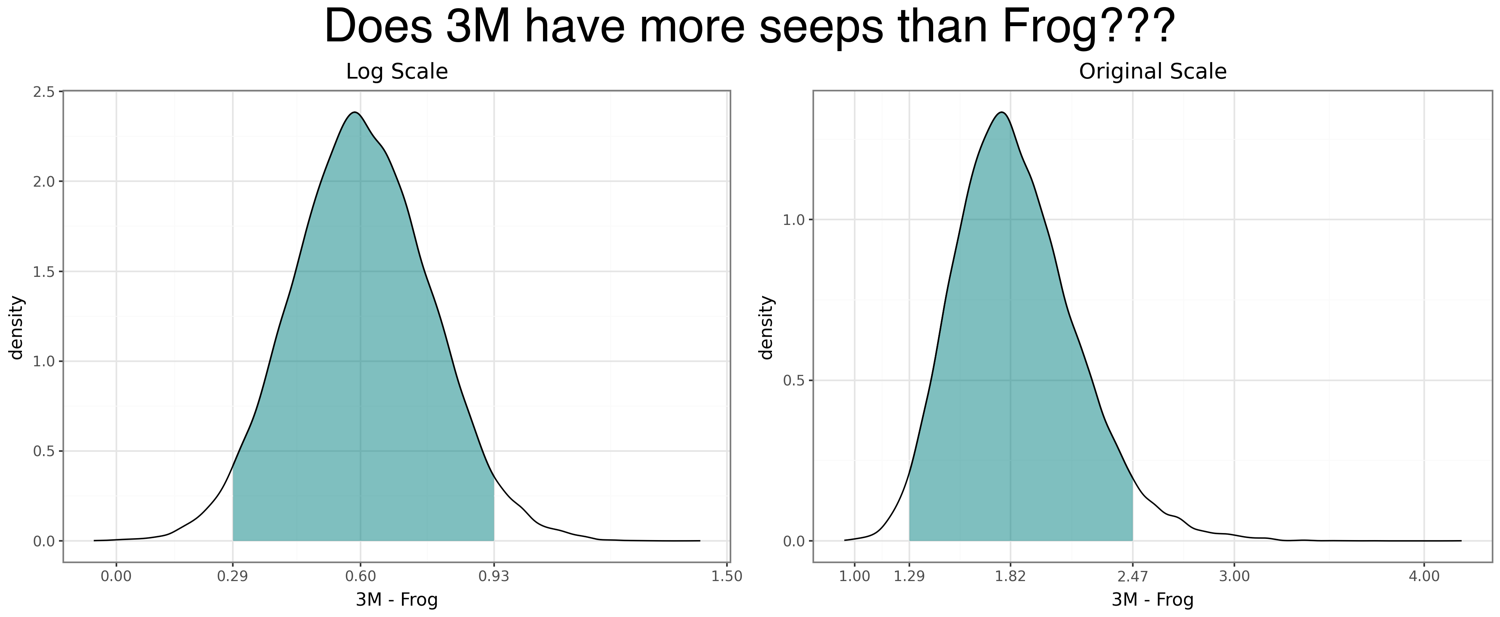

In [34]:
plot1 = ggplot(aes(x = "to_plot")) \
+ geom_density_highlight(region=hdi_log,
                         fill = "teal",
                         alpha = 0.5) \
+ geom_density() \
+ labs(
    title = "Log Scale",
    x = "3M - Frog"
) \
+ scale_x_continuous(breaks = [0, hdi_log[0], np.median(to_plot),hdi_log[1], 1.5])

plot2 = ggplot(aes(x = "orig_to_plot")) \
+ geom_density_highlight(region=hdi_orig,
                         fill = "teal",
                         alpha = 0.5) \
+ geom_density() \
+ labs(
    title = "Original Scale",
    x = "3M - Frog"
) \
+ scale_x_continuous(breaks = [1, hdi_orig[0], np.median(orig_to_plot),hdi_orig[1], 3,4])
PGrid({"plot1" : plot1,
       "plot2" : plot2}).quilt("plot1 + plot2", title="Does 3M have more seeps than Frog???", size = (1500, 2000))

We can see from these 94% high density intervals that the Frog tape results in 1.3 to 2.47 times less seeps underneath the tape than 3M tape with 94% probability. We have sufficient evidence here to say conclusively that for flat wood surfaces, Frog tape is nearly twice as good at preventing seepages as 3M tape.

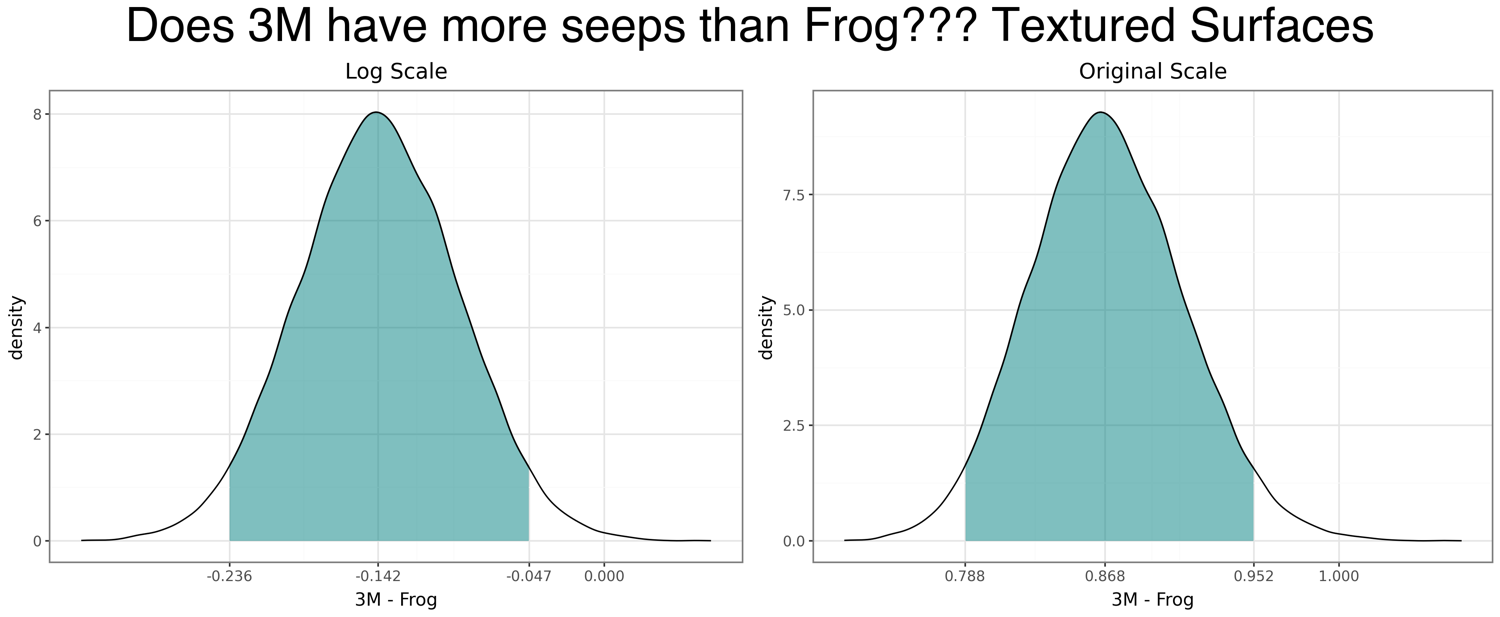

In [35]:
to_plot = c_dist[::10, 2]
orig_to_plot = np.exp(to_plot)
hdi_log = az.hdi(c_dist[:,2])
hdi_orig = az.hdi(np.exp(c_dist[:,2]))

plot1 = ggplot(aes(x = "to_plot")) \
+ geom_density_highlight(region=hdi_log,
                         fill = "teal",
                         alpha = 0.5) \
+ geom_density() \
+ labs(
    title = "Log Scale",
    x = "3M - Frog"
) \
+ scale_x_continuous(breaks = [0, hdi_log[0], np.median(to_plot),hdi_log[1], 1.5])

plot2 = ggplot(aes(x = "orig_to_plot")) \
+ geom_density_highlight(region=hdi_orig,
                         fill = "teal",
                         alpha = 0.5) \
+ geom_density() \
+ labs(
    title = "Original Scale",
    x = "3M - Frog"
) \
+ scale_x_continuous(breaks = [1, hdi_orig[0], np.median(orig_to_plot),hdi_orig[1], 3,4])
PGrid({"plot1" : plot1,
       "plot2" : plot2}).quilt("plot1 + plot2", title="Does 3M have more seeps than Frog??? Textured Surfaces", size = (1500, 2000))

For the 